In [1]:
from tqdm import trange

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from string import punctuation
from nltk.corpus import stopwords
from pymystem3 import Mystem
from sklearn.feature_extraction.text import CountVectorizer

from bertopic import BERTopic

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
! python3.11 -m pip install bertopic

In [ ]:
! python3.11 -m pip install gensim

# Тематическое моделирование

## 1. Выбор алгоритма для тематического моделирования

Рассмотрим следующие алгоритмы:
1. PLSA
2. Robust PLSA
3. LDA
4. NMF
5. LSI
6. Кластеризация (BERTopic)

Исходя из EDA, можно сделать следующие выводы:
- выбросов слов примерно 6.41% относительно всех слов в корпусе;
- в данных присутствует только текст и метка, указывающая на тональность текста;
- в данных нет пропусков;
- в данных присуствуют опечатки;
- размер датасета относительно большой: 210989 записей и 25207507 слов (включая стоп-слова);
- основная задача – выделение тематик текстов.

На основе данных выводов из EDA можно отсеять следующие алгоритмы.
NMF зачастую используется, когда требуется неотрицательность данных. В данной задаче этого не требуется.
LSI используется для снижения размерности, интерпретация полученных тем может быть сильно затруднена или невозможна. Также плохая асимптотика при больших документах затрудняет процесс обучения модели.
Так как в данном случае темы выделяются из отзывов, то количество терминов и специфичных слов относительно небольшое (6.41%). Поэтому использовать робастную версию PLSA не имеет смысла.

Среди оставшихся моделей выбрана модель BERTopic, так как она объединяет SBERT эмбединги и TF-IDF. Данная модель состоит из следующих этапов.
1. Получение эмбедингов на обученной нейросети (SBERT).
2. Сокращение размерности пространства признаков с помощью UMAP.
3. Кластеризация на полученных из UMAP признаках с помощью HDBSCAN.
4. Токенизация с помощью CountVectorizer.
5. Получение кластеров с помощью модификации TF-IDF представления (c-TF-IDF). 

REFERENCE: "BERTopic: Neural topic modeling with a class-based TF-IDF procedure"


В данной модели будет использоваться иерархическое тематическое моделирование, так как оно позволяет более качественно и просто выбирать количество тем (попросту разбивая темы на подтемы).


## 2. Выбор метрик оценивания

Для оценивания качества модели выбраны метрики:
- coherence;
- heatmap;
- ручная проверка интерпритируемости.

## 3. Предварительная обработка текстовых данных

**Piplene.**
1. Удаление пунктуации.
2. Приведение к нижнему регистру.
3. Удаление стоп-слов.
4. CountVectorizer

In [3]:
df = pd.read_csv("../data/datasets.csv")["text"]

In [4]:
russian_stopwords = stopwords.words("russian")
mystem = Mystem() 

def clean(sentence):
    # удаление всех символов, не являющихся буквами или цифрами
    sentence = re.sub("[^0-9a-zA-Zа-яА-Я]+", " ", sentence)
    
    # приведение к нижнему ригистру
    sentence = sentence.lower()

    # удаление лишних пробелов в тексте
    sentence = re.sub("  ", " ", sentence)

    # замена буквы ё на е
    sentence = re.sub("ё", "е", sentence)

    # удаление переносов строки
    sentence = re.sub("\n", ".", sentence)

    # удаление стопслов
    tokens = mystem.lemmatize(sentence)
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    res_sentence = " ".join(tokens)
    
    return res_sentence

cleaned_df = df.apply(clean)


# 4. Инициализация модели и ее обучение

In [5]:

vectorizer_model = CountVectorizer(ngram_range=(1, 2))
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='russian', 
    calculate_probabilities=True,
    verbose=True
)

In [6]:
topics, probs = topic_model.fit_transform(cleaned_df)

2024-02-18 18:50:19,381 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/6594 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
topic_model.save("../models/topic_model", serialization="pickle")

In [5]:
topic_model = BERTopic.load("../models/topic_model")

In [6]:
# Создание иерархических тем
hierarchical_topics = topic_model.hierarchical_topics(cleaned_df)

100%|██████████| 870/870 [00:39<00:00, 22.10it/s]


# 5. Представление полученных результатов обучения модели

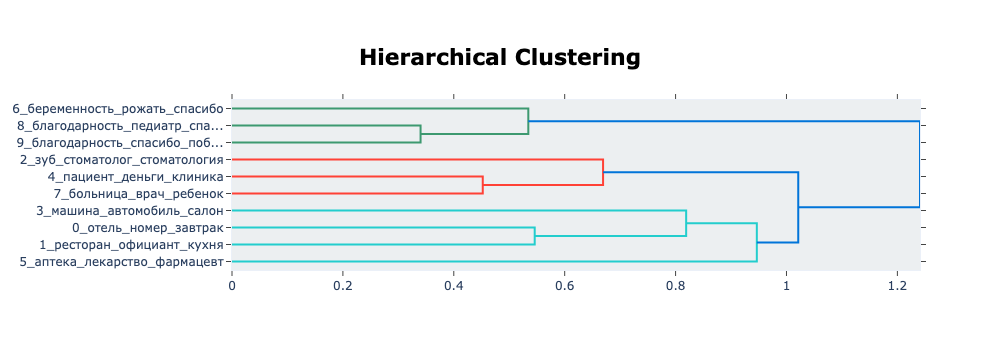

In [11]:
# Вывод топ-10 тем и их иерархий
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics, top_n_topics=10)
fig.show("png")

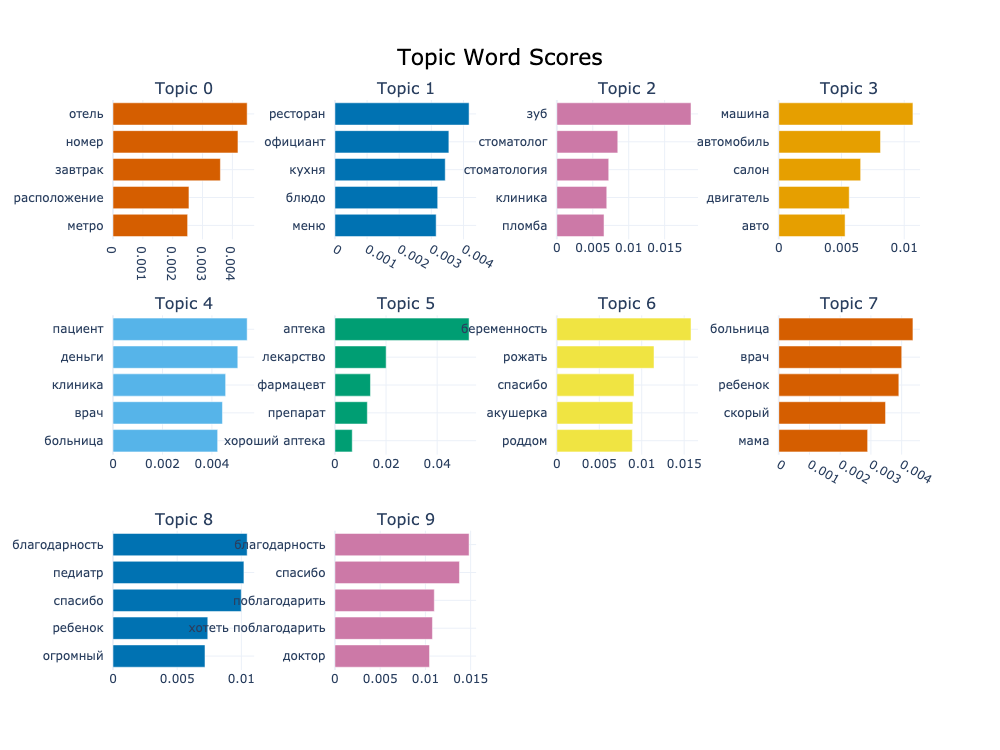

In [12]:
# Вывод топ-10 тем и их ключевых слов
fig = topic_model.visualize_barchart(top_n_topics=10)
fig.show("png")

In [13]:
# Частоты текстов для каждой темы
topic_model.get_topic_freq().head(8)

Topic  Count
9      -1  67844
1       0  56038
7       1  31293
5       2   8691
21      3   5481
13      4   2090
11      5   1714
38      6   1186

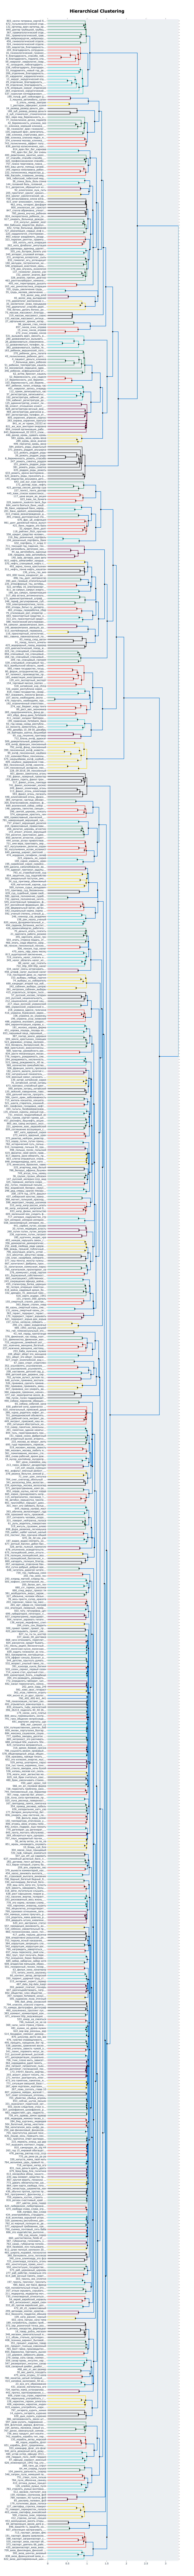

In [14]:
# Вывод всех полученных тем
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.show("png")

# 6. Оценка полученной модели

In [15]:
tokens = []
for i in range(cleaned_df.shape[0]):
    tokens.append(cleaned_df[i].split(" "))

dictionary=Dictionary(tokens)

In [16]:
def get_top_n_topics(topics, ntopics):
    """
    Функция получения списков слов первых ntopics тем из словаря тем topics
    """
    res_topics = []
    for i in range(-1, ntopics - 1):
        res_topics.append([top_j[0] for top_j in topics[i]])
    return res_topics

In [17]:
def calculate_coherence_list(max_topics):

    topics_num_list = []
    coherence_list = []

    for ntopic in trange(1, max_topics + 1):
        top_n_topics = get_top_n_topics(topic_model.get_topics(), ntopic)
        cm = CoherenceModel(topics=top_n_topics, texts=tokens, dictionary=dictionary, coherence='c_v')
        coherence = cm.get_coherence()

        topics_num_list.append(ntopic)
        coherence_list.append(coherence)
    
    return topics_num_list, coherence_list

In [18]:
MAX_TOPICS_NUM = 40 # максимальное количество тем для подсчета когерентности

topics_num_list, coherence_list = calculate_coherence_list(MAX_TOPICS_NUM)

100%|██████████| 40/40 [09:59<00:00, 15.00s/it]


Text(0, 0.5, 'Coherence')

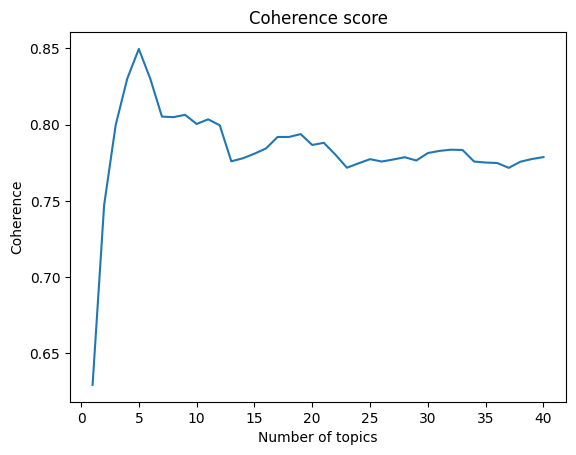

In [19]:
sns.lineplot(x=topics_num_list, y=coherence_list)
plt.title("Coherence score")
plt.xlabel("Number of topics")
plt.ylabel("Coherence")

На данном графике можно заметить, что максимальная когерентность достигается при количестве тем = 5.

# 7. Визуализация тем 

In [8]:
fig = topic_model.visualize_documents(cleaned_df, topics=[0, 1, 2, 3, 4])
fig.show("png")

KeyboardInterrupt: 

In [ ]:
fig = topic_model.visualize_topics(top_n_topics=5)
fig.show("png")

In [ ]:
fig = topic_model.visualize_heatmap(topics=[0, 1, 2, 3, 4])
fig.show("png")

На вышеприведенном графике отображена матрица сходства, на которой можно заметить, что темы под номерами [0, 1] и [2, 4] явзяются близкими друг к другу. Для устранения данной близости можно разбить эти темы на подтемы и выборочно объединить их вручную, уменьшив близость.

# 8. Варианты  дальнейшего улучшения тематического моделирования для имеющегося набора данных

В предлагаемом датасете содержаться тексты различных отзывов, поэтому в них достаточно много опечаток. Для устранения проблемы опечаток имеет смысл обучить эмбеддинги не на словах, а на парых-тройках букв (или BPE).

Также стоит на выходе (или при обучении модели) ограничить появление темы минимальным количеством текстов (например 100 текстов). После чего необходимо будет провести сокращение количества тем по средствам кластерного анализа (например, встроенными методами BERTopic).

Еще одним способом улучшения модели является fine-tuning с помощью LLM или Репрезентативных моделей.